### Type III: Collaborative Filtering based Recommendation System

It works on the basic idea that people with similar characteristics have similar interests in movies. 

There are 2 types of Collaborative Filtering Techniques:


>   *User-Based*:  Here we assume that similar people have similar liking. If user A and user B have watched a lot of similar movies and have rated them almost equally, then it can be inferred that their interests match. Thus we can recommend movies that A have liked to B. 

>   *Item-Based*: Here we take into consideration the content of movies as well and not only user similarity. Here we find those movies which the user would enjoy based on his previously rated movies.

User Based Collaborative Filtering is a very common and highly used approach for movielens dataset because of the fact that:


*   It is easy to implement.
*   It is context independent.
*   It gives better results that content based recommendation system.

But this approach is not the best. Recommending movies without taking into consideration the content of the movie would never give best results. 

<a href="https://imgbb.com/"><img src="https://i.ibb.co/C5hfzyf/Item-based-Collaborative-Filtering.png" alt="Item-based-Collaborative-Filtering" border="0"></a>

Thus we tried to implement an **item based recommendation system** with our movies dataset.

Firstly, we start of by reading the data. To find similarity between items, we are using 5 different types of feature combinations:


1.   Genre, Crew
2.   Cast, Keywords
3.   Genre, Crew, Production Countries
4.   Genre, Production Countries, Keywords
5.   Genre, Crew, Production Countries, Keywords

The above combinations were made on our basic understanding of what all features influence our liking for a movie.

The data is combined from multiple files: keywords.csv, credits.csv, movies_metadata.csv, ratings.csv




#### Mount & Imports

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My\ Drive/DataScience\ Project/the-movies-dataset

/content/drive/My Drive/DataScience Project/the-movies-dataset


In [0]:
ls

 BestFeatureVector.csv    Errors1.csv    links_small.csv
 cosSimScore.csv          Errors-S.csv   movies_metadata.csv
 credits.csv              keywords.csv   ratings.csv
'Customer Feedback.csv'   links.csv      ratings_small.csv


In [0]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.corpus import stopwords
from ast import literal_eval
import pandas as pd, numpy as np,matplotlib.pyplot as plt
import nltk, re, string
from prettytable import PrettyTable
from prettytable import from_csv
nltk.download('stopwords')
stopWord = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Functions

In [0]:
def removeStopWord(tokens): #Function removing stop words and punctuation
    global stopWord
    low = tokens.lower()
    cl = re.compile('_') #remove punctuation
    loweredTokens = re.split(';|_|!|#|@|$|%|\^|&|\*|\(|\)|:|\'|\"| |\.|\,|',low)
    fr = []
    for i in loweredTokens:
        if(i not in stopWord):
            fr.append(i)
    return (' ').join(fr)

In [0]:
def binarise(y_train): #Function to create a binary vector for features
  mlb = MultiLabelBinarizer()
  y_Bin = mlb.fit_transform(y_train)
  clsNames = mlb.classes_
  return y_Bin, clsNames

In [0]:
def vectorForm(df,col): #Creates feature vector
    temp = [[] for i in range(len(df))]
    colNames = []
    for i in col:
        val,colName = binarise(df[i])
        temp = np.hstack((temp,val))
        colNames.extend(colName)
    vectDf = pd.DataFrame(temp,columns=colNames)
    finlVec = pd.concat([vectDf,df.rating],axis=1)
    return finlVec

In [0]:
def recommend(test,r,sim,mu,title,n): #Recommends top n movies
    predRating = dict()
    for i in test.index:
        sum1 = 0
        sum2 = 0
        for j in test.index:
            sum1 += (sim[i][j]*(r[j]-mu))
            sum2 += sim[i][j]
        predRating[i] = round(mu + (sum1/sum2),2)
    sortedScore = sorted(predRating.items(), key=lambda x: x[1],reverse=True) #Sorting in decreasing order on the basis of similarity score
    topScores = sortedScore[1:n+1]
    movies = [i[0] for i in topScores]
    return list(title[movies])

#### Reading Data and preprocessing

In [0]:
keyDf = pd.read_csv('keywords.csv')
credDf = pd.read_csv('credits.csv')
metaDf = pd.read_csv('movies_metadata.csv')
ratDf = pd.read_csv('ratings.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
print(keyDf.shape,credDf.shape,metaDf.shape,ratDf.shape)

(46419, 2) (45476, 3) (45466, 24) (26024289, 4)


In [0]:
ratDf.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [0]:
ratDf.rename(columns = {"movieId": "id"},inplace=True) #Renaming movieId col to id for merging

In [0]:
ratDf.columns

Index(['userId', 'id', 'rating', 'timestamp'], dtype='object')

In [0]:
metaDf.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [0]:
keyDf.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [0]:
credDf.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


> Info about DF

In [0]:
print(keyDf.info())
print()
print(credDf.info())
print()
print(metaDf.info())
print()
print(ratDf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
id          46419 non-null int64
keywords    46419 non-null object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
cast    45476 non-null object
crew    45476 non-null object
id      45476 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.0+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 

> Converting int to str

In [0]:
keyDf.id = keyDf.id.apply(str)
credDf.id = credDf.id.apply(str)
ratDf.id = ratDf.id.apply(str)

> Sampling of data

In [0]:
maxUserRat = list(ratDf.userId[ratDf.userId == ratDf.userId.value_counts().index[0]].index) #Picking users with maximum ratings count i.e. 45811
sampleRatDf = ratDf.iloc[maxUserRat,:] #Sampling maximum users data based on ratings
sampleRatDf.drop(['userId','timestamp'],axis=1,inplace=True) #Dropping off timestamp & userId
sampleRatDf.index = range(len(sampleRatDf)) #Resetting indexes
sampleRatDf.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,rating
0,1,4.0
1,2,3.0
2,6,4.0
3,9,2.5
4,10,3.0


> Merging on movieid column

In [0]:
merKeyDf = metaDf.merge(keyDf,on='id')
merCredDf = merKeyDf.merge(credDf,on='id')
mergedDf = merCredDf.merge(sampleRatDf,on='id')

In [0]:
mergedDf.shape

(3634, 28)

In [0]:
finalDf = mergedDf[['id','title','genres','keywords','cast','crew','production_countries','rating']]
finalDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3634 entries, 0 to 3633
Data columns (total 8 columns):
id                      3634 non-null object
title                   3634 non-null object
genres                  3634 non-null object
keywords                3634 non-null object
cast                    3634 non-null object
crew                    3634 non-null object
production_countries    3634 non-null object
rating                  3634 non-null float64
dtypes: float64(1), object(7)
memory usage: 255.5+ KB


> Preprocessing (Converting structures to list & removing stop words or punctutation)

In [0]:
finalDf['genres'] = finalDf['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [removeStopWord(i['name']) for i in x] if isinstance(x, list) else [])
finalDf['cast'] = finalDf['cast'].fillna('[]').apply(literal_eval).apply(lambda x: [removeStopWord(i['name']) for i in x] if isinstance(x, list) else [])
finalDf['crew'] = finalDf['crew'].fillna('[]').apply(literal_eval).apply(lambda x: [removeStopWord(i['name']) for i in x] if isinstance(x, list) else [])
finalDf['production_countries'] = finalDf['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [removeStopWord(i['name']) for i in x] if isinstance(x, list) else [])
finalDf['keywords'] = finalDf['keywords'].fillna('[]').apply(literal_eval).apply(lambda x: [removeStopWord(i['name']) for i in x] if isinstance(x, list) else [])

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value i

In [0]:
finalDf.head()

,id,title,genres,keywords,cast,crew,production_countries,rating
0,8844,Jumanji,"[adventure, fantasy, family]","[board game, disappearance, based children boo...","[robin williams, jonathan hyde, kirsten dunst,...","[larry j franco, jonathan hensleigh, james ho...",[united states america],4.0
1,949,Heat,"[action, crime, drama, thriller]","[robbery, detective, bank, obsession, chase, s...","[al pacino, robert de niro, val kilmer, jon vo...","[michael mann, michael mann, art linson, micha...",[united states america],4.0
2,1408,Cutthroat Island,"[action, adventure]","[exotic island, treasure, map, ship, scalp, pi...","[geena davis, matthew modine, frank langella, ...","[peter levy, maggie gray, norman garwood, mari...","[france, germany, italy, united states america]",3.5
3,524,Casino,"[drama, crime]","[poker, drug abuse, 1970s, overdose, illegal p...","[robert de niro, sharon stone, joe pesci, jame...","[martin scorsese, barbara de fina, robert rich...","[france, united states america]",4.0
4,8012,Get Shorty,"[comedy, thriller, crime]","[gambling, miami, based novel, job, murder, tr...","[john travolta, gene hackman, rene russo, dann...","[barry sonnenfeld, elmore leonard, danny devit...",[united states america],3.5


#### Building Recommendation System

The recommendation system is build by following following steps:

Following set of feature combinations is used:
1. Genre, Crew
2. Crew, Keywords
3. Genre ,Crew ,Production Countries
4. Genre, Production Countries, Keywords
5. Genre, Crew, Production Countries, Keywords

Below Steps are followed for all combinations of features:
1. Given dataset for a specific user is split into train - test ratio.
2. Using the training data, where we have user rating corresponding to each movie vector, we train the regressor to predict user's ratings on movies from the test dataset.
3. Now we have predicted user rating for movie i and average rating of movie by all the users. 
4. Using RMSE and MAE, we find the est set of features which is able to generalise the user's interests.

Using the best set of features, we find cosine similarity between movies features. Using the below mentioned formula, we find rating of movie for a user.

<a href="https://imgbb.com/"><img src="https://i.ibb.co/vm4NK9C/Screenshot-from-2019-11-30-13-05-34.png" alt="Screenshot-from-2019-11-30-13-05-34" border="0"></a>

<a href="https://imgbb.com/"><img src="https://i.ibb.co/98MbCQN/Screenshot-from-2019-11-30-13-09-58.png" alt="Screenshot-from-2019-11-30-13-09-58" border="0"></a>

Using predicted rating for each movie, we sort the best rated movies for user 'u' and recommend.

In [0]:
'''Dictionary for few combination of features'''

feat = {0:['genres','crew'],
        1:['Crew','keywords'],
        2:['genres','crew','production_countries'],
        3:['genres','production_countries','keywords'],
        4:['genres','crew','production_countries','keywords']
        }

In [0]:
'''Running for all combination and calculating MAE and RMSE'''
testrmse = []
testmae = []
trainrmse = []
trainmae = []
j=0
for i in feat.values():
    j+=1
    # print('\nFor: ',i)
    vector = vectorForm(finalDf,i)
    vector = vector.values
    X = vector[:,:-1]
    y = vector[:,-1]
    y = y.astype(float)
    print(X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
    X_tr, X_ts, y_tr, y_ts = train_test_split(X_train, y_train, test_size=0.2,shuffle=False)
    clftst = KNeighborsRegressor(n_neighbors=5)
    clftrn = KNeighborsRegressor(n_neighbors=5)
    clftst.fit(X_train, y_train)
    clftrn.fit(X_tr,y_tr)
    predTest = clftst.predict(X_test)
    predTrain = clftrn.predict(X_ts)
    trm = mean_absolute_error(y_ts,predTrain)
    trr = mean_squared_error(y_ts,predTrain)
    tsm = mean_absolute_error(y_test,predTest)
    tsr = mean_squared_error(y_test,predTest)
    testrmse.append(np.sqrt(tsr))
    testmae.append(tsm) 
    trainrmse.append(np.sqrt(trr))
    trainmae.append(trm) 
    x.add_row([str(j), i, X.shape, trm, np.sqrt(trr),tsm, np.sqrt(tsr) ])

In [0]:
scoreDf.to_csv('Errors.csv',index=None) #Dumping errors in csv

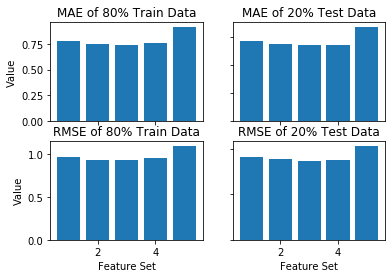

+---------------------------------------------+--------------+--------------+--------------+--------------+
|                   Features                  |   Test MAE   |  Test RMSE   |  Train MAE   |  Train RMSE  |
+---------------------------------------------+--------------+--------------+--------------+--------------+
|                 Genre, Crew                 | 0.6829436039 | 0.8827476799 | 0.7599656357 | 0.9556038375 |
|                Crew, Keywords               | 0.8418156809 | 1.036022444  | 0.9125429553 | 1.097067318  |
|      Genre ,Crew ,Production Countries      | 0.7138927098 | 0.9162599656 | 0.776975945  | 0.9657538053 |
|    Genre, Production Countries, Keywords    | 0.6777166437 | 0.8672158173 | 0.7374570447 | 0.9352398299 |
| Genre, Crew, Production Countries, Keywords | 0.6905089409 | 0.8905587631 | 0.7451890034 | 0.9341828485 |
+---------------------------------------------+--------------+--------------+--------------+--------------+


In [0]:
x = [1,2,3,4,5]
ylbl = [0.0,0.2,0.4,0.6,0.8,1.0]
error = pd.read_csv('Errors1.csv')

fig, axs = plt.subplots(2, 2)
axs[0, 0].bar(x,error['Train MAE'])
axs[0, 0].set_title('MAE of 80% Train Data')
axs[0, 1].bar(x,error['Test MAE'])
axs[0, 1].set_title('MAE of 20% Test Data')
axs[1, 0].bar(x,error['Train RMSE'])
axs[1, 0].set_title('RMSE of 80% Train Data')
axs[1, 1].bar(x,error['Test RMSE'])
axs[1, 1].set_title('RMSE of 20% Test Data')

for ax in axs.flat:
    ax.set(xlabel='Feature Set', ylabel='Value')

for ax in axs.flat:
    ax.label_outer()
plt.show()


with open("Errors-S.csv", "r") as fp: 
    x = from_csv(fp)
print(x)

RMSE value close to 0 indicates that the regression model is able to generalise well. We take the set of attributes for which we get the lowest RMSE and MAE Errors. This our case, the required set of attriutes is: Genre, Production Countries, Keywords

We can also see that Test RMSE and Train RMSE are almost equal. Thus we can conclude that our model doesn't overfit/ underfit on the data.



> Choosing Best Set of features according to minimum error

In [0]:
mmin = 1
rmin = 1
for i in range(len(testrmse)):
    if(mmin > testmae[i] and rmin > testrmse[i]):
        mmin = testmae[i]
        rmin = testrmse[i]

In [0]:
print(mmin,rmin)

0.6777166437414031 0.8672158172725218


In [0]:
bestFeat = feat[testmae.index(mmin)]
print(bestFeat)

['genres', 'production_countries', 'keywords']


In [0]:
bestFeatVector = vectorForm(finalDf,bestFeat)
bestFeatVector.to_csv('BestFeatureVector.csv',index=None) #Dumpping best feature vector based on min MAE and RMSE to csv

> Cosine Similarity

In [0]:
bfv = pd.read_csv('BestFeatureVector.csv') #Dumpping best feature vector in csv
simMatrix = cosine_similarity(bfv.values,bfv.values)
pd.DataFrame(simMatrix).to_csv('cosSimScore.csv',index=None) #Dumpping similarity matrix in csv file
simMatrix = pd.read_csv('cosSimScore.csv')
# simMatrix.shape
sim = simMatrix.values
mu = round(bfv.rating.mean(),2) #Mean rating for user who has done max ratings
X = bfv.iloc[:,bfv.columns!='rating']
y = bfv.rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)

> Finding Recommendations 

In [0]:
recommend(X_test,y_test,sim,mu,finalDf.title,10)

['Due cuori, una cappella',
 'Samay: When Time Strikes',
 'Virasat',
 'The Last Relic',
 'The Colour Out of Space',
 'Shocking Asia',
 'Koyla',
 'The Incredible Kung Fu Master',
 'The Mystery of Chess Boxing',
 'Afterparty']